In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Define paths
train_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
test_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"

In [4]:
# Define classes
classes = ["Covid", "Normal", "Viral Pneumonia"]

In [5]:
# Print number of images in each class
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    print(f"Train {class_name}: {len(os.listdir(train_class_dir))} images")
    print(f"Test {class_name}: {len(os.listdir(test_class_dir))} images")

Train Covid: 111 images
Test Covid: 26 images
Train Normal: 70 images
Test Normal: 20 images
Train Viral Pneumonia: 70 images
Test Viral Pneumonia: 20 images


In [6]:
# Data Preparation
img_size = (2746, 2382)
batch_size = 8

In [7]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 251 images belonging to 3 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 66 images belonging to 3 classes.


In [10]:
# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(2746, 2382, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=output)

In [12]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Model Training
epochs = 6
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724936905.219539     936 service.cc:145] XLA service 0x7f94b4004880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724936905.219609     936 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724936905.219616     936 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-08-29 13:08:42.895075: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=3,k3=0} for conv (f32[8,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]

18/31 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4932 - loss: 0.9560

2024-08-29 13:11:00.755982: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[3,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-29 13:11:01.220156: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.46429538s
Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[3,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForwar

31/31 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.5486 - loss: 0.8756
Epoch 2/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.6250 - loss: 0.6629
Epoch 3/6


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7960 - loss: 0.5145
Epoch 4/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - accuracy: 0.8750 - loss: 0.3449
Epoch 5/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8459 - loss: 0.3807
Epoch 6/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 1.0000 - loss: 0.1930


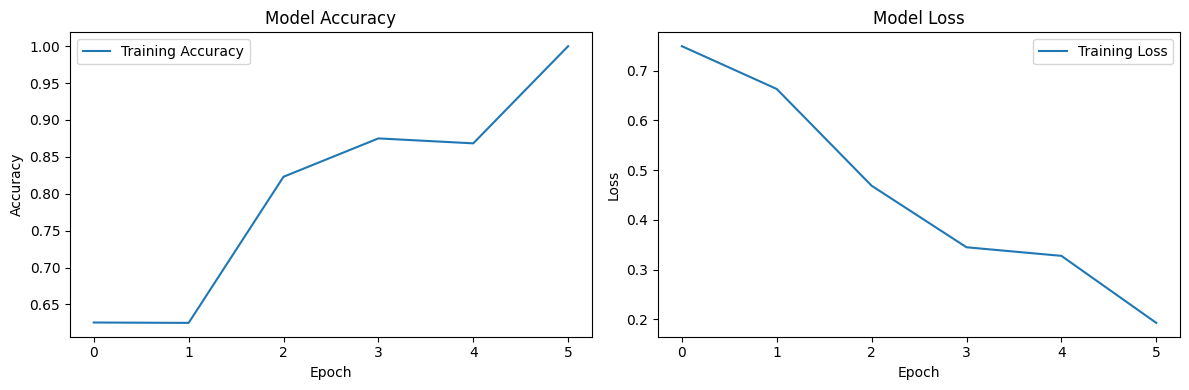

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9862 - loss: 0.2017

2024-08-29 13:14:23.132032: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[2,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-29 13:14:24.445653: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.313751617s
Trying algorithm eng4{} for conv (f32[2,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wai

9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9859 - loss: 0.2022
Test Accuracy: 0.9848


In [17]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


In [18]:
# Generate classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Classification Report:
                 precision    recall  f1-score   support

          Covid       0.96      1.00      0.98        26
         Normal       1.00      0.95      0.97        20
Viral Pneumonia       1.00      1.00      1.00        20

       accuracy                           0.98        66
      macro avg       0.99      0.98      0.99        66
   weighted avg       0.99      0.98      0.98        66



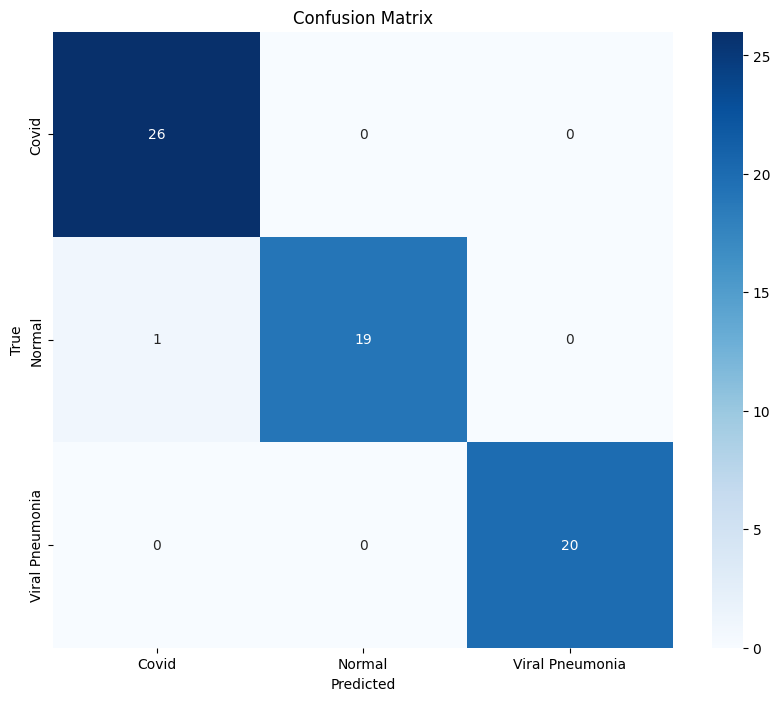

In [19]:
# Create and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()